In [1]:
from dtw import dtw
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib import style
#style.use("gunplot")
from sklearn.cluster import KMeans
%matplotlib inline
from osgeo import gdal
from sklearn.externals import joblib
import pandas as pd
import datetime
from matplotlib import pyplot as plt
import time as t
import math

In [2]:
def euclid_dist(t1,t2):
    return np.sqrt(sum((t1-t2)**2))

In [3]:
def DTWDistance(s1, s2):
    DTW={}
    
    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
		
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

In [4]:
def DTWDistance(s1, s2,w):
    DTW={}
    
    w = max(w, abs(len(s1)-len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

In [5]:
def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):
        
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    
    return np.sqrt(LB_sum)

In [6]:
from sklearn.metrics import classification_report

def knn(train,test,w):
    preds=[]
    for ind,i in enumerate(test):
        min_dist=float('inf')
        closest_seq=[]
        print ind
        print min_dist
        for j in train:
            if LB_Keogh(i[:-1],j[:-1],5)<min_dist:
                dist=DTWDistance(i[:-1],j[:-1],w)
                if dist<min_dist:
                    min_dist=dist
                    closest_seq=j
        preds.append(closest_seq[-1])
    return classification_report(test[:,-1],preds)

In [92]:
print knn(E,E,4)

0
inf
1
inf
             precision    recall  f1-score   support

     1648.0       1.00      1.00      1.00         1
     1655.0       1.00      1.00      1.00         1

avg / total       1.00      1.00      1.00         2



In [42]:
from GdalHandlemulti import MultiImages

In [43]:
def resample1(array):
    r_array = array.copy()
    r_array[:] = 0
    rows = array.shape[0]
    cols = array.shape[1]
    for y in range(1, rows - 1):
        for x in range(1, cols - 1):
            if array[y,x] != 0 :
                r_array[y, x] = 1
    return r_array
def find_evi_timeseries(mask, year):
    #files = ["/home/faizan/Pakistan/EVI/"+str(year)+"/Larkana.%d%03d"  % (year, i) + ".tif" for i in range(1, 363) ]
    files = ["/home/faizan/HDD1/EVI/"+str(year)+"/Pak_crop.%d%03d"  % (year, i) + ".sindh_d.tif" for i in range(1, 363) ]
    mimage = MultiImages(files)
    AllArrays = mimage.Images2Arrays()
    results = [0 for i in AllArrays[0]]
    for i in np.where(mask.flatten() == 1)[0]:
        array = AllArrays.T[i]
        results[i] = array.tolist()
    del AllArrays
    return results


In [44]:
#path="/home/faizan/Pakistan/EVI/2002/Larkana.2002099.tif"
path="/home/faizan/HDD1/EVI/2009/Pak_crop.2009099.sindh_d.tif"
ds = gdal.Open(path)
array = ds.ReadAsArray()
r_array = resample1(array)


In [45]:
mask = r_array
for year in range(2009,2010):
    EVI = find_evi_timeseries(r_array, year)
    #image = GImage(path)
    #image.Array2Tiff(out_name="/home/faizan/Pakistan/EVI/"+str(year)+"/Larkana.%d_max_evi.tif" % (year), Array=max_date)

In [142]:
len(EVI)


90

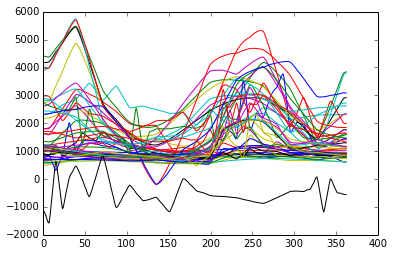

In [46]:
mask = r_array
time = [i for i in range(1,363)]
for i in np.where(mask.flatten() == 1)[0]: 
    plt.plot(time,EVI[i])
plt.show()

In [23]:
import random

def k_means_clust(data,num_clust,num_iter,w=5):
    centroids=random.sample(data,num_clust)
    counter=0
    for n in range(num_iter):
        counter+=1
        #print counter
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                if LB_Keogh(i,j,5)<min_dist:
                    cur_dist=DTWDistance(i,j,w)
                    if cur_dist<min_dist:
                        min_dist=cur_dist
                        closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust]=[ind]
    
        #recalculate centroids of clusters
        for key in assignments:
            #print assignments
            clust_sum=0
            for k in assignments[key]:
                clust_sum=clust_sum+data[k]
                
            centroids[key]=[m/len(assignments[key]) for m in clust_sum]
    print counter
    return centroids

In [47]:
data=[]
for d in np.where(mask.flatten() == 1)[0]: 
    data.append(EVI[d])
data=np.array(data)


In [48]:
data= data/10000

In [49]:
data

array([[ 0.0787,  0.0792,  0.0796, ...,  0.0606,  0.0607,  0.0609],
       [ 0.1123,  0.113 ,  0.1138, ...,  0.1776,  0.1771,  0.1764],
       [ 0.1808,  0.1804,  0.1802, ...,  0.1623,  0.1622,  0.1619],
       ..., 
       [ 0.1217,  0.1217,  0.1216, ...,  0.1171,  0.1171,  0.1171],
       [ 0.1174,  0.1174,  0.1174, ...,  0.1172,  0.1171,  0.1171],
       [ 0.0999,  0.0994,  0.0989, ...,  0.0848,  0.0847,  0.0847]])

In [50]:
for i in range(len(data)):
    minn= min(data[i])
    print minn

0.0606
0.0761
0.0631
0.1851
0.0938
0.0494
0.0847
0.0527
0.1486
0.0904
0.0568
0.0871
0.0756
0.1218
0.0658
0.0558
0.0954
0.0834
0.1129
0.1527
0.0681
0.0305
0.0701
-0.0201
0.112
0.1024
0.0563
0.0719
0.0879
0.091
0.1477
0.122
0.0603
0.0673
0.0737
0.0617
0.0847
0.0959
0.1244
0.0686
0.0732
-0.1578
-0.0188
0.0735
0.0861
0.0641
0.0758
0.0482


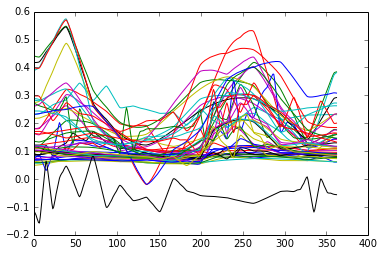

In [51]:
mask = r_array
time = [i for i in range(1,363)]
for i in range(len(data)): 
    plt.plot(time,data[i])
plt.show()

10
10
10
10
10
10


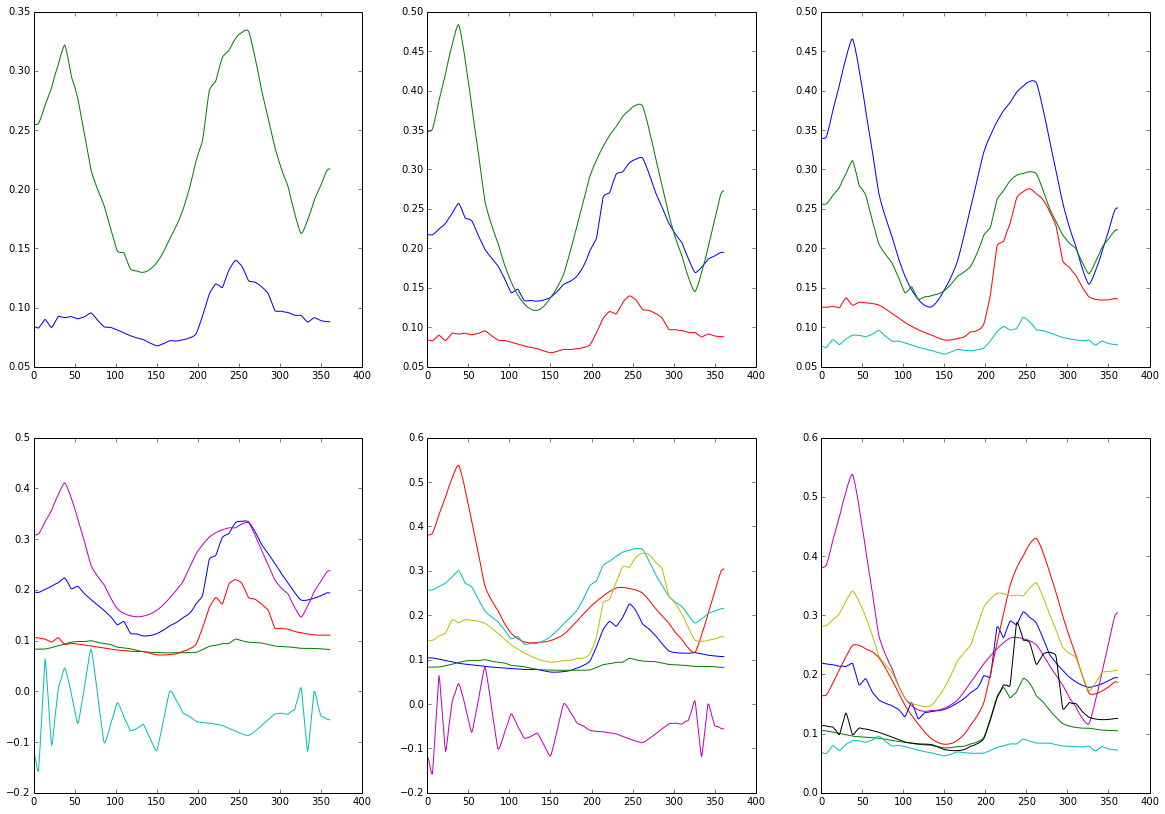

In [52]:
plt.figure(figsize=(20, 14))
for clu in xrange(2,8):
    centroids=k_means_clust(data,clu,10,5)
    for i in centroids:
            plt.subplot(2,3,clu-1)
            plt.plot(i)
plt.show()

In [132]:
centroids=random.sample(data,2)
for ind,i in enumerate(data):
    for c_ind,j in enumerate(centroids):
        K=LB_Keogh(i,j,5)
        print K
#centroids=k_means_clust(data,2,5,3)


26037.2779875
4618.81748936
13206.1524298
28336.1976984
20346.9457167
40254.0678069
16546.2377597
33934.5399556
12934.6296429
29763.5338124
28774.7751164
1524.35625757
229584.874761
203605.265838
24368.5704135
7355.23908517
15994.9285713
17931.5001603
25600.274686
48305.3935291
22735.7829203
6752.00333235
28775.6332858
1607.42433726
229584.874761
203605.265838
229584.874761
203605.265838
22336.7648956
7619.83497197
22190.3248962
29703.103592
21372.6727622
41269.5122942
26090.2086807
1597.00626173
27314.8141125
0.0
229584.874761
203605.265838
229584.874761
203605.265838
20510.7697808
9270.1677439
23187.332339
36973.6354988
9445.71177837
25717.0631683
11016.7674025
34143.3501578
24917.7668141
3116.80156571
24669.6249059
2947.5433839
229584.874761
203605.265838
229584.874761
203605.265838
25594.2773291
4933.76316821
28853.4153091
52574.4591508
11744.9711366
30850.6612733
17111.0883932
41175.618611
26243.0427161
2429.79011439
229584.874761
203605.265838
24816.0355013
3360.04657706
22717.64

In [136]:
len(centroids[0])

362

In [121]:
data=np.array(data)

In [122]:
data

array([[  787.,   792.,   796., ...,   606.,   607.,   609.],
       [ 1123.,  1130.,  1138., ...,  1776.,  1771.,  1764.],
       [ 1808.,  1804.,  1802., ...,  1623.,  1622.,  1619.],
       ..., 
       [ 1217.,  1217.,  1216., ...,  1171.,  1171.,  1171.],
       [ 1174.,  1174.,  1174., ...,  1172.,  1171.,  1171.],
       [  999.,   994.,   989., ...,   848.,   847.,   847.]])

In [56]:
year = 2009
mask =r_array
files = ["/home/faizan/Pakistan/EVI/"+str(year)+"/Larkana.%d%03d"  % (year, i) + ".tif" for i in range(1, 363) ]
mimage = MultiImages(files)
AllArrays = mimage.Images2Arrays()
results = [0 for i in AllArrays[0]]
for i in np.where(mask.flatten() == 1)[0]:
    array = AllArrays.T[i]
    results[i] = array

In [54]:
results = [0 for i in AllArrays[0]]

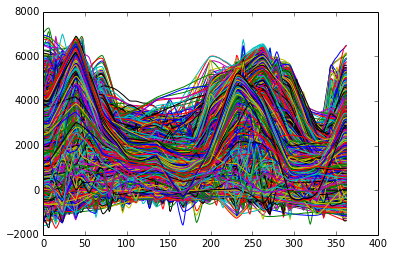

In [59]:
time = [i for i in range(1,363)]
for i in np.where(mask.flatten() == 1)[0]: 
    plt.plot(time,results[i])
plt.show()

In [60]:
import random

def k_means_clust(data,num_clust,num_iter,w=5):
    centroids=random.sample(data,num_clust)
    counter=0
    for n in range(num_iter):
        counter+=1
        #print counter
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                if LB_Keogh(i,j,5)<min_dist:
                    cur_dist=DTWDistance(i,j,w)
                    if cur_dist<min_dist:
                        min_dist=cur_dist
                        closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust]=[ind]
    
        #recalculate centroids of clusters
        for key in assignments:
            #print assignments
            clust_sum=0
            for k in assignments[key]:
                clust_sum=clust_sum+data[k]
                
            centroids[key]=[m/len(assignments[key]) for m in clust_sum]
    print counter
    return centroids

In [62]:

EVI=[]
for i in np.where(mask.flatten() == 1)[0]: 
    EVI.append(results[i])

plt.figure(figsize=(20, 14))
for clu in xrange(2,8):
    centroids=k_means_clust(EVI,clu,10,5)
    for i in centroids:
            plt.subplot(2,3,clu-1)
            plt.plot(i)
plt.show()

KeyboardInterrupt: 

In [64]:
results

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


ValueError: setting an array element with a sequence.

In [71]:
EVI1

0

In [6]:
EVI_path= "/home/faizan/HDD1/EVI/CSV/Pak_crop_all_point_evi.csv"
data1 = pd.read_csv(EVI_path)
for p in range(49):

    data = data1[data1["ID"] == p]
    dates = [datetime.datetime.strptime(str(k), "%Y%j") for k in data["DATE"]]
    data.index = dates
    dummy = data[data.index.year > 2008]
    dummy = dummy[dummy.index.year < 2010]
    #dummy = dummy[dummy.index.month > 5]
    time = dummy.index
    evi  = dummy["EVI"]
    time1=dummy["DATE"]
    if p==0:
        comb=evi
    else:
        comb=np.vstack((comb, evi))
    

In [7]:
len(comb[2])

361

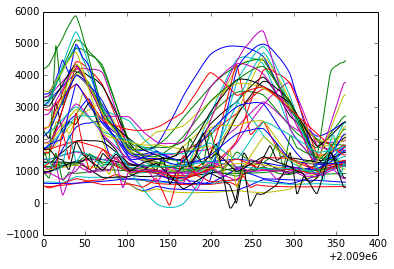

In [8]:
for i in range(49):  
    plt.plot(time1,comb[i])
plt.show()


In [13]:
import random

def k_means_clust(data,num_clust,num_iter,w=5):
    centroids=random.sample(data,num_clust)
    counter=0
    for n in range(num_iter):
        counter+=1
        #print counter
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                if LB_Keogh(i,j,5)<min_dist:
                    cur_dist=DTWDistance(i,j,w)
                    if cur_dist<min_dist:
                        min_dist=cur_dist
                        closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust]=[ind]
    
        #recalculate centroids of clusters
        for key in assignments:
            #print assignments
            clust_sum=0
            for k in assignments[key]:
                clust_sum=clust_sum+data[k]
                
            centroids[key]=[m/len(assignments[key]) for m in clust_sum]
    print counter
    return centroids

In [ ]:
ind=2
assignments={}
closest_clust=3
if closest_clust in assignments:
    assignments[closest_clust].append(ind)
else:
    assignments[closest_clust]=[]

10
10
10
10
10
10


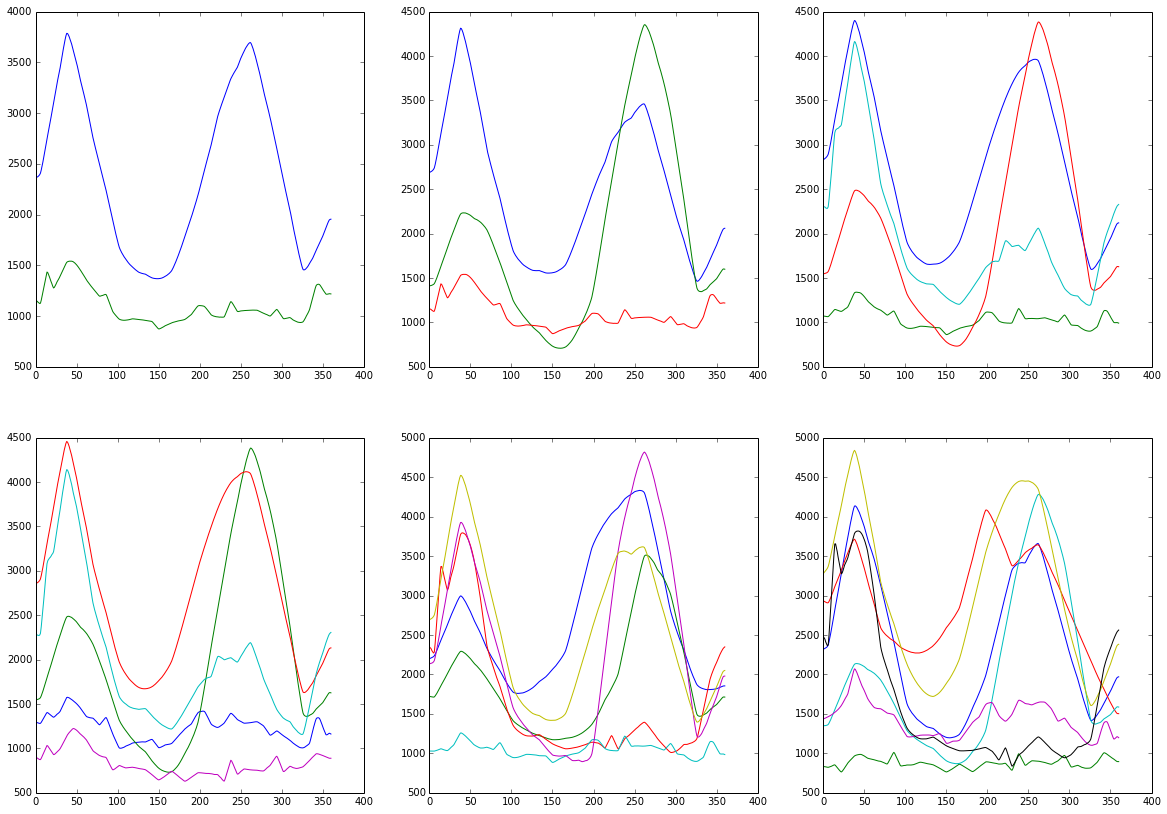

In [21]:
#train = np.genfromtxt('datasets/train.csv', delimiter='\t')
#test = np.genfromtxt('datasets/test.csv', delimiter='\t')

plt.figure(figsize=(20, 14))

for clu in xrange(2,8):
    centroids=k_means_clust(comb,clu,10,5)
    for i in centroids:
            plt.subplot(2,3,clu-1)
            plt.plot(i)
plt.show()

In [19]:
plt.savefig("/home/faizan/Desktop/clustering1.png")


In [256]:
centroids=random.sample(comb,6)
for c_ind,j in enumerate(centroids):
    #print j
    print c_ind

0
1
2
3
4
5


In [257]:
centroids

[array([  -19.,    67.,   162.,   269.,   365.,   462.,   570.,   679.,
          787.,   894.,   994.,  1091.,  1202.,  1305.,  1402.,  1476.,
         1481.,  1458.,  1428.,  1386.,  1348.,  1308.,  1256.,  1205.,
         1165.,  1128.,  1092.,  1054.,  1006.,   958.,   911.,   871.,
          850.,   838.,   826.,   817.,   808.,   799.,   793.,   786.,
          770.,   752.,   735.,   719.,   705.,   692.,   680.,   670.,
          665.,   663.,   662.,   662.,   661.,   662.,   663.,   665.,
          669.,   673.,   678.,   683.,   689.,   695.,   702.,   707.,
          708.,   707.,   705.,   704.,   704.,   705.,   706.,   707.,
          708.,   710.,   713.,   717.,   720.,   725.,   730.,   738.,
          752.,   770.,   788.,   808.,   828.,   848.,   870.,   891.,
          911.,   931.,   951.,   972.,   993.,  1015.,  1036.,  1058.,
         1080.,  1102.,  1125.,  1147.,  1168.,  1189.,  1210.,  1231.,
         1253.,  1276.,  1297.,  1318.,  1338.,  1358.,  1376., 

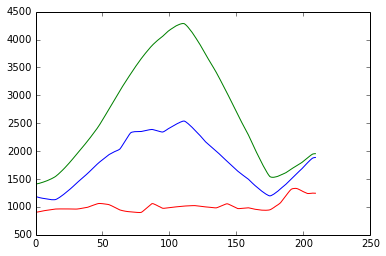

In [234]:
centroids=k_means_clust(comb,3,10,5)
for i in centroids:    
    plt.plot(i)
plt.show()

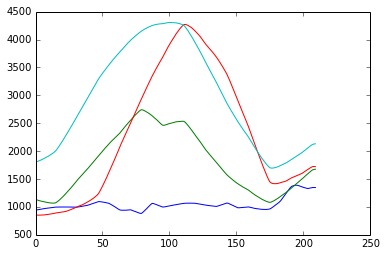

In [228]:
centroids=k_means_clust(comb,4,10,5)
for i in centroids:    
    plt.plot(i)
plt.show()

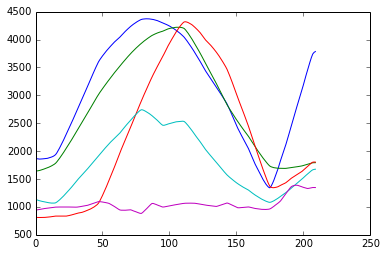

In [229]:
centroids=k_means_clust(comb,5,10,5)
for i in centroids:    
    plt.plot(i)
plt.show()

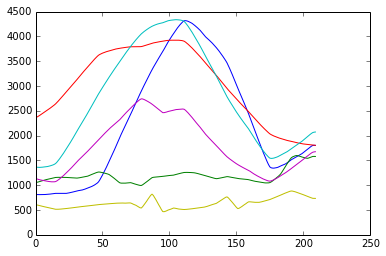

In [230]:
centroids=k_means_clust(comb,6,10,5)
for i in centroids:    
    plt.plot(i)
plt.show()

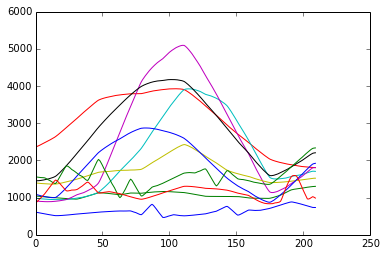

In [231]:
centroids=k_means_clust(comb,10,10,5)
for i in centroids:    
    plt.plot(i)
plt.show()

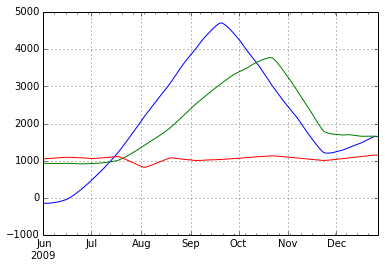

In [168]:
evi.plot()
evi2.plot()
evi3.plot()

In [188]:
centroids=k_means_clust(data,2,10,5)
for i in centroids:
    
    plt.plot(i)

plt.show()


1


TypeError: 'int' object is not iterable

In [7]:
train = np.genfromtxt('/home/faizan/Desktop/te.csv', delimiter='\t')

In [8]:
data=np.vstack((train[:,:-1],train[:,:-1]))

In [9]:
data

array([[-1.4139728 , -1.1620647 , -0.62417387, ...,  1.3630718 ,
         0.72553966, -0.88008903],
       [-1.115918  ,  0.23716141,  1.6308144 , ..., -1.3665346 ,
        -0.66266115, -1.2489139 ],
       [-1.2857446 , -0.06746462, -0.55532233, ..., -1.6829035 ,
         0.89153789,  1.5520388 ],
       ..., 
       [-0.10808234, -0.97877163, -0.55061271, ...,  0.78514926,
         0.36594352,  0.8416499 ],
       [-0.63008704, -0.5506395 ,  0.58111432, ..., -0.49145736,
        -0.96981644, -0.49904942],
       [ 0.81303753,  0.01441759,  1.2853706 , ...,  0.93264908,
         0.15278736, -0.03264544]])

10


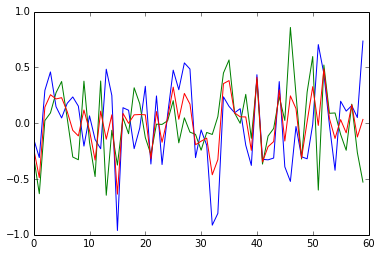

In [14]:
centroids=k_means_clust(data,3,10,5)
for i in centroids:
    
    plt.plot(i)

plt.show()

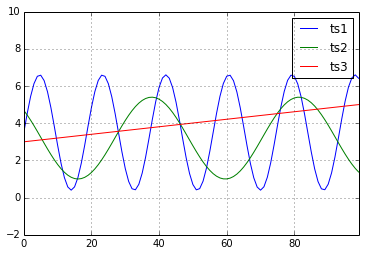

In [62]:
x=np.linspace(0,50,100)
ts1=pd.Series(3.1*np.sin(x/1.5)+3.5)
ts2=pd.Series(2.2*np.sin(x/3.5+2.4)+3.2)
ts3=pd.Series(0.04*x+3.0)

ts1.plot()
ts2.plot()
ts3.plot()

plt.ylim(-2,10)
plt.legend(['ts1','ts2','ts3'])
plt.show()

In [ ]:

D=[]
for i in range(len(evi)):
    D.append([time1[i], evi[i]])


#clf= KMeans(n_clusters=3)
clf= KMeans(n_init=20,n_clusters=3)

clf.fit(D)

centroid = clf.cluster_centers_
lables= clf.labels_

print centroid 
print lables

colors = ["g,", "r,", "c", "b", "c", "g", "d", "k"]

for l in range(len(D)):
    #print("cor:", D[l], "lab:", lables[l])
    plt.plot(D[l][0], D[l][1], colors[lables[l]], markersize=10)
    
plt.scatter(centroid[:,0], centroid[:,1], marker="x", s=150, linewidths=5, zorder=10)
plt.show()